# Topic modeling with tmtoolkit

Adapted from: https://github.com/WZBSocialScienceCenter/tmtoolkit/blob/master/doc/source/topic_modeling.ipynb

## An example document-term matrix

tmtoolkit supports topic models that are computed from document-term matrices (DTMs).

In [1]:
import random
import os
import logging
import warnings
import numpy as np

try:
    import tmtoolkit
except ModuleNotFoundError:
    !pip install tmtoolkit[recommended,lda,sklearn,gensim]
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.corpus import Corpus
from tmtoolkit.preprocess import TMPreproc

In [2]:
random.seed(20191120)   # to make the sampling reproducible
np.set_printoptions(precision=5)

DATADIR = '../../data/documenters/illinois'
_corpus = Corpus()


def documents(datadir=DATADIR):
    for fn in os.listdir(datadir):
        yield fn, open(os.path.join(datadir, fn)).read()

for fn, text in documents():
    _corpus.add_doc(fn[:-4], text)

_corpus

<Corpus [17237 documents]>

(array([1.6794e+04, 2.8100e+02, 1.0700e+02, 3.6000e+01, 1.3000e+01,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([      0. ,  217464.5,  434929. ,  652393.5,  869858. , 1087322.5,
        1304787. , 1522251.5, 1739716. , 1957180.5, 2174645. ]),
 <a list of 10 Patch objects>)

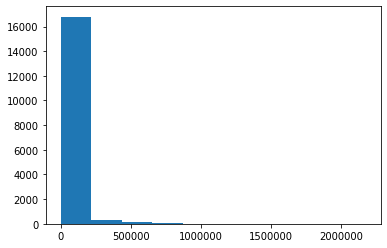

In [3]:
import matplotlib

matplotlib.pyplot.hist(_corpus.doc_lengths.values())

In [4]:
from statistics import mean, stdev
doclen_mean = mean(_corpus.doc_lengths.values())
doclen_std = stdev(_corpus.doc_lengths.values())
print('Mean doc length:', doclen_mean)
print('Std:', doclen_std)

Mean doc length: 27797.95039740094
Std: 79844.54599522066


In [5]:
# For topic modeling, document sizes should be similar.
# If there is a lot of variance, we might look at a subset of documents of similar size
_corpus = _corpus.filter_by_max_length(doclen_mean + doclen_std)
_corpus

<Corpus [16279 documents]>

In [6]:
# A large corpus can be heavy to process. Here we take a sample of 5000 docs
corpus = _corpus.sample(1000)
corpus.filter_characters()

<Corpus [1000 documents]>

In [7]:
try:
    import nltk
except ModuleNotFoundError:
    !pip install nltk
    import nltk
try:
    nltk.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

## Pre-process the corpus

In [8]:
preproc = TMPreproc(corpus)
preproc = preproc \
    .tokens_to_lowercase() \
    .remove_special_chars_in_tokens() \
    .add_stopwords(['mr', 'mrs', 'ms']) \
    .clean_tokens(
        remove_numbers=True,
        remove_shorter_than=3,
        remove_longer_than=20
    ) \
    .remove_common_tokens(df_threshold=0.85) \
    .remove_uncommon_tokens(df_threshold=0.01)
    
    #.remove_common_tokens(df_threshold=0.001) \
    #.remove_uncommon_tokens(df_threshold=0.8)
preproc.pos_tag()
preproc.filter_for_pos(['N', 'V'])
preproc.lemmatize()
preproc.n_docs, preproc.vocabulary_size

(1000, 4001)

In [9]:
preproc.tokens_datatable

,doc,position,token,meta_pos
0,5015821-Agenda,0,committee,NN
1,5015821-Agenda,1,member,NNS
2,5015821-Agenda,2,chair,NN
3,5015821-Agenda,3,glenn,NNS
4,5015821-Agenda,4,meeting,NN
...,...,...,...,...
48,6570508-Committee-on-License-and-Consumer-Prot...,48,share,VBD
49,6570508-Committee-on-License-and-Consumer-Prot...,49,housing,NN
50,6570508-Committee-on-License-and-Consumer-Prot...,50,ordinance,NN
51,6570508-Committee-on-License-and-Consumer-Prot...,51,mitt,NN


## Create document labels array

In [10]:
doc_labels = np.array(preproc.doc_labels)
doc_labels[:10]

array(['5015821-Agenda', '5015824-Agenda',
       '5015887-Zoning-Board-of-Appeals-2010-03-19-Agenda',
       '5015888-Zoning-Board-of-Appeals-2016-01-15-Map',
       '5015890-Zoning-Board-of-Appeals-2009-04-17-Agenda',
       '5015896-Zoning-Board-of-Appeals-2012-03-16-Agenda',
       '5015899-Zoning-Board-of-Appeals-2015-03-20-Map',
       '5015904-Zoning-Board-of-Appeals-2017-12-15-Minutes',
       '5015932-Minutes',
       '5015946-Managed-Care-Committee-Meetings-2018-10-18-Item'],
      dtype='<U58')

## Get the Document-term-matrix and the vocabulary

In [11]:
vocab = np.array(preproc.vocabulary)
dtm = preproc.dtm

del preproc # once we have the dtm, we no longer need the preprocessed corpus
dtm

<1000x4001 sparse matrix of type '<class 'numpy.int32'>'
	with 180707 stored elements in Compressed Sparse Row format>

We now have a sparse DTM, a list of document labels `doc_labels` that represent the rows of both DTMs and vocabulary array `vocab` that represent the columns of the DTM. We will use this data for the remainder of the notebook.

### suppress unwanted logging

In [12]:
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False

warnings.filterwarnings('ignore')

## Evaluation of topic model

tmtoolkit provides several metrics for comparing and evaluating topic models. This can be used for finding a good hyperparameter set for a given dataset, e.g. a good combination of the number of topics and concentration paramaters (often called alpha and beta in literature). For some background on hyperparameters in topic modeling, see [this blog post](https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/).

The heart of the model evaluation process is the function [evaluate_topic_models()](api.rst#tmtoolkit.topicmod.tm_lda.evaluate_topic_models), which is available for all three topic modeling packages. We stick with lda and import that function from [topicmod.tm_lda](api.rst#module-tmtoolkit.topicmod.tm_lda). It is similar to [compute_models_parallel()](api.rst#tmtoolkit.topicmod.tm_lda.compute_models_parallel) as it accepts varying and constant hyperparameters. However, it doesn't only compute the models in parallel, but also applies several metrics to these models in order to evaluate them. This can be controlled with the `metric` parameter that accepts a string or a list of strings that specify the used metric(s). These metrics refer to functions that are implemented in [topicmod.evaluate](api.rst#module-tmtoolkit.topicmod.evaluate).

Each topic modeling sub-module defines two important sequences: `AVAILABLE_METRICS` and `DEFAULT_METRICS`. The former lists all available metrics for that sub-module, the latter lists the default metrics that are used when you don't specify anything with the `metric` parameter. Let's have a look at both sequences in [topicmod.tm_lda](api.rst#module-tmtoolkit.topicmod.tm_lda):

In [13]:
tm_lda.AVAILABLE_METRICS

('loglikelihood',
 'cao_juan_2009',
 'arun_2010',
 'coherence_mimno_2011',
 'griffiths_2004',
 'held_out_documents_wallach09',
 'coherence_gensim_u_mass',
 'coherence_gensim_c_v',
 'coherence_gensim_c_uci',
 'coherence_gensim_c_npmi')

In [14]:
tm_lda.DEFAULT_METRICS

('cao_juan_2009', 'arun_2010', 'coherence_mimno_2011')

For details about the metrics and the academic references, see the respective implementations in the [topicmod.evaluate](api.rst#module-tmtoolkit.topicmod.evaluate) module.

### variable parameters

In [21]:
var_params = [{'n_topics': k, 'alpha': 1/(10**k), 'eta':0.001 } for k in range(1, 201, 5)]

### constant parameters

In [22]:
const_params = {
    'n_iter': 100,
    'random_state': 20191122  # to make results reproducible
}

## Evaluate

We will now run the model evaluations with [evaluate_topic_models()](api.rst#tmtoolkit.topicmod.tm_lda.evaluate_topic_models). For each candidate hyperparameter set, a model can be generated and evaluated in parallel. We will do this now for the DTM. Our candidate values for the number of topics k. We make alpha and beta vary with respect to k. We also set `return_models=True` which means to retain the generated models in the evaluation results.

This step will take some time, depending on the corpus size, vocabulary size, number of steps in var_params, the number of iterations calculated.

During experimentation, you may want to tweak these values to make things run a bit faster until you have a sense of what the right parameters should be.

In [23]:
eval_results = evaluate_topic_models(dtm,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     return_models=True)
eval_results[:3]

[({'n_topics': 1,
   'alpha': 0.1,
   'eta': 0.001,
   'n_iter': 100,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7fdcdcc4c2b0>,
   'cao_juan_2009': nan,
   'arun_2010': 101.0017158025303,
   'coherence_mimno_2011': -0.7351898988081527}),
 ({'n_topics': 6,
   'alpha': 1e-06,
   'eta': 0.001,
   'n_iter': 100,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7fdcd57aa198>,
   'cao_juan_2009': 0.22421130211860138,
   'arun_2010': 61.14999743492854,
   'coherence_mimno_2011': -0.9195377595312518}),
 ({'n_topics': 11,
   'alpha': 1e-11,
   'eta': 0.001,
   'n_iter': 100,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7fdcd57aa208>,
   'cao_juan_2009': 0.20473146593698258,
   'arun_2010': 49.20982230123449,
   'coherence_mimno_2011': -0.9567918570199055})]

The evaluation results are a list with pairs of hyperparameters and their evaluation results for each metric. Additionally, there is the generated model for each hyperparameter set.

## results by n_topics

We now use [results_by_parameter()](api.rst#tmtoolkit.topicmod.evaluate.results_by_parameter), which takes the "raw" evaluation results and sorts them by a specific hyperparameter, in this case `n_topics`. This is important because this is the way that the function for visualizing evaluation results, [plot_eval_results()](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results), expects the input.

In [24]:
eval_results_by_ntopics = results_by_parameter(eval_results, 'n_topics')
eval_results_by_ntopics[:3]

[(1,
  {'model': <lda.lda.LDA at 0x7fdcdcc4c2b0>,
   'cao_juan_2009': nan,
   'arun_2010': 101.0017158025303,
   'coherence_mimno_2011': -0.7351898988081527}),
 (6,
  {'model': <lda.lda.LDA at 0x7fdcd57aa198>,
   'cao_juan_2009': 0.22421130211860138,
   'arun_2010': 61.14999743492854,
   'coherence_mimno_2011': -0.9195377595312518}),
 (11,
  {'model': <lda.lda.LDA at 0x7fdcd57aa208>,
   'cao_juan_2009': 0.20473146593698258,
   'arun_2010': 49.20982230123449,
   'coherence_mimno_2011': -0.9567918570199055})]

We can now see the results for each metric across the specified range of number of topics using [plot_eval_results()](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results):

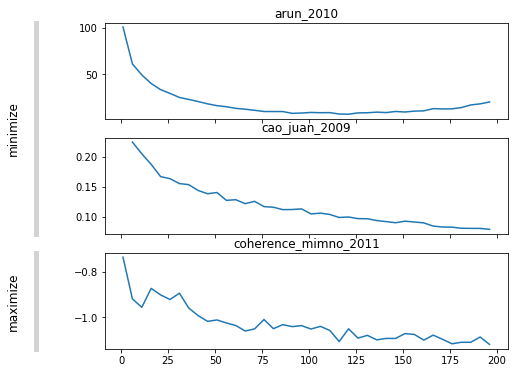

In [25]:
from tmtoolkit.topicmod.visualize import plot_eval_results

plot_eval_results(eval_results_by_ntopics);

These charts do not "elbow" as cleanly as we would like, but we will set the number of topics, `n_topics`, to about 30. We don't have to generate a model with these hyperparameters again, because it's already in the evaluation results (thanks to `return_models=True`). We extract the model from there in order to use it in the rest of the chapter.

In [26]:
best_k = 26
best_tm = [m for k, m in eval_results_by_ntopics if k == best_k][0]['model']
best_tm.n_topics, best_tm.alpha, best_tm.eta  # just to make sure

(26, 1e-26, 0.001)

## Visualize the topics

### Interactive visualization with pyLDAVis

The [pyLDAVis package](https://pyldavis.readthedocs.io/) offers a great interactive tool to explore a topic model. The tmtoolkit function [parameters_for_ldavis()](api.rst#tmtoolkit.topicmod.visualize.generate_wordclouds_for_document_topics) allows to prepare your topic model data for this package so that you can easily pass it on to pyLDAVis.

In [27]:
from tmtoolkit.topicmod.visualize import parameters_for_ldavis

ldavis_params = parameters_for_ldavis(best_tm.topic_word_,
                                      best_tm.doc_topic_,
                                      dtm,
                                      vocab)
try:
    import pyLDAvis
except ModuleNotFoundError:
    !pip install pyldavis
    import pyLDAvis
pyLDAvis.enable_notebook()
pyLDAvis.prepare(**ldavis_params)

     |████████████████████████████████| 1.6MB 46.5MB/s eta 0:00:01
     |████████████████████████████████| 829kB 75.4MB/s eta 0:00:01
     |████████████████████████████████| 552kB 76.1MB/s eta 0:00:01
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=96445 sha256=cd86dbe854f991b911d15a01f2765e4a8ee85293217315021fb9f3eaa3cbc126
  Stored in directory: /home/ec2-user/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491095 sha256=977e5414593d41273ecf4695590e774a8eac3d058c64b46aa9766af33e69e2af
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32056 sha256=c64a213d53a7e02bbeedb30b9116cba12533d9e323d5baf2824192375828a3d1
  Stored in directory: /home/ec2-user/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.119769  0.084890       1        1  5.516346
1      0.299278 -0.014239       2        1  3.063906
2      0.023289  0.185997       3        1  5.827177
3      0.237848 -0.024390       4        1  3.598503
4     -0.067557 -0.023741       5        1  4.407442
5      0.123298 -0.000817       6        1  2.165622
6      0.316786  0.044842       7        1  1.607816
7     -0.127209  0.222428       8        1  4.665015
8     -0.080731 -0.047761       9        1  4.556888
9     -0.102279  0.097783      10        1  5.060630
10    -0.048005 -0.202100      11        1  3.086041
11    -0.117188 -0.071419      12        1  3.735741
12    -0.036336 -0.107792      13        1  2.622142
13    -0.082467  0.169660      14        1  3.055052
14    -0.117289 -0.163771      15        1  4.455200
15    -0.000146 -0.064472      16        1  5.619911
16     0.273876 -0.067536      17        1  4.533545
17     0.196858  0.064479      18        1  3.185314
18    -0.135087  0.035764      19        1  3.926908
19     0.066448  0.015573      20        1  3.368566
20    -0.141873 -0.202832      21        1  3.996265
21    -0.117615  0.011407      22        1  2.756697
22    -0.088197 -0.164825      23        1  3.433362
23    -0.087816  0.109358      24        1  5.823823
24    -0.078514  0.185958      25        1  3.711594
25     0.010396 -0.072444      26        1  2.220490, topic_info=              Term          Freq         Total Category  logprob  loglift
850       contract   7020.000000   7020.000000  Default  30.0000  30.0000
751   commissioner   7799.000000   7799.000000  Default  29.0000  29.0000
448          board  12679.000000  12679.000000  Default  28.0000  28.0000
343         avenue   3809.000000   3809.000000  Default  27.0000  27.0000
2690        permit   3473.000000   3473.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
2856      property     88.979492   2855.663123  Topic26  -5.2259   0.3388
2162      location     83.980700    885.910362  Topic26  -5.2837   1.4514
2570         order     85.980217   4643.499351  Topic26  -5.2601  -0.1817
2307          meet     84.980458   1978.736919  Topic26  -5.2718   0.6596
55          action     81.981183   1394.825093  Topic26  -5.3078   0.9734

[2012 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1        13  0.974857     30th
2         8  0.974772      3rd
3         2  0.974829     47th
6         5  0.963836  abandon
6         9  0.036213  abandon
...     ...       ...      ...
3999      6  0.003730     zone
3999     10  0.004145     zone
3999     17  0.640777     zone
3999     18  0.005803     zone
3999     21  0.005803     zone

[5947 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

### Generating labels for topics

In topic modeling, topics are numbered because they're *abstract* – they're simply a probability distribution across all words in the vocabulary. Still, it's useful to give them labels for better identification. The function [generate_topic_labels_from_top_words()](api.rst#tmtoolkit.topicmod.model_stats.generate_topic_labels_from_top_words) is very useful for that, as it finds labels according to the most "relevant" words in each topic. We'll later see how we can identify the most relevant words per topic using a special [relevance statistic](#Topic-word-relevance). Note that you can adjust the weight of the relevance measure for the ranking by using the parameter `lambda_` which is in range $[0, 1]$.

The function requires at least the topic-word and document-topic distributions from the model, the document lengths and the vocabulary. It then finds the minimum number of relevant words that uniquely label each topic. You can also use a fixed number for that minimum number with the parameter `n_words`.

In [28]:
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

doc_lengths = doc_lengths(dtm)
topic_labels = generate_topic_labels_from_top_words(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    doc_lengths,
    vocab,
    lambda_=0.6
)

topic_labels

array(['1_housing_cha', '2_permit_avenue', '3_program_agency',
       '4_space_district', '5_county_cook', '6_school_student',
       '7_maintain_know', '8_health_care', '9_county_committee',
       '10_attorney_payment', '11_approve_motion', '12_time_board',
       '13_casino_license', '14_representation_case', '15_board_member',
       '16_authorize_development', '17_application_zone', '18_work_exist',
       '19_director_page', '20_state_go', '21_commissioner_chairman',
       '22_trustee_annuity', '23_preserve_commissioner',
       '24_amount_account', '25_contract_bid', '26_martin_llc'],
      dtype='<U24')

As we can see, two words are necessary to label each topic uniquely. By default, each label is prefixed with a number. You can change that with the parameter `labels_format`.

Let's have a look at the top words for a specific topic. We can use [ldamodel_top_topic_words()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_topic_words) for that from the module [topicmod.model_io](api.rst#module-tmtoolkit.topicmod.model_io), which we will have a closer look at [later](#Displaying-and-exporting-topic-modeling-results):

In [29]:
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

top_topic_word = ldamodel_top_topic_words(best_tm.topic_word_,
                                          vocab,
                                          row_labels=topic_labels)
top_topic_word

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
1_housing_cha,board (0.04238),housing (0.04012),contract (0.03667),commissioner (0.03193),cha (0.02867),item (0.02461),resolution (0.01836),service (0.01744),amount (0.01615),authority (0.01612)
2_permit_avenue,permit (0.09859),avenue (0.09854),street (0.06623),disable (0.05332),park (0.04724),zone (0.02916),side (0.02732),foot (0.02478),point (0.02009),ave (0.01764)
3_program_agency,program (0.03151),service (0.01897),fund (0.0177),provide (0.01319),community (0.01236),agency (0.01156),support (0.01114),include (0.01112),plan (0.0111),staff (0.009323)
4_space_district,district (0.04477),space (0.02852),ordinance (0.02844),building (0.02646),propose (0.02289),change (0.02277),unit (0.02266),development (0.02188),llc (0.01879),property (0.01793)
5_county_cook,county (0.06132),cook (0.04437),board (0.04386),property (0.03287),commissioner (0.02809),resolution (0.01723),whereas (0.01686),ordinance (0.01613),propose (0.01546),year (0.01506)
6_school_student,school (0.03041),include (0.01988),propose (0.0187),project (0.01703),page (0.01554),meeting (0.01474),report (0.01468),student (0.01462),city (0.01387),community (0.01369)
7_maintain_know,maintain (0.1074),premise (0.0895),know (0.07899),street (0.05372),construct (0.04971),avenue (0.04838),locate (0.04454),sign (0.04112),rightofway (0.03937),use (0.03837)
8_health_care,health (0.07925),contract (0.04287),service (0.03528),care (0.03117),request (0.02841),system (0.02832),hospital (0.02384),cook (0.02254),quality (0.01886),center (0.01869)
9_county_committee,county (0.03989),committee (0.0229),cook (0.01492),business (0.0141),illinois (0.01201),provide (0.01077),meeting (0.01057),include (0.01045),employee (0.01042),act (0.01018)


### Marginal topic and word distributions

We'll now focus on the marginal topic and word distributions. Let's get the marginal topic distribution first by using [marginal_topic_distrib()](api.rst#tmtoolkit.topicmod.model_stats.marginal_topic_distrib):

In [30]:
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib

marg_topic = marginal_topic_distrib(best_tm.doc_topic_, doc_lengths)
marg_topic

array([0.05516, 0.03064, 0.05827, 0.03599, 0.04407, 0.02166, 0.01608,
       0.04665, 0.04557, 0.05061, 0.03086, 0.03736, 0.02622, 0.03055,
       0.04455, 0.0562 , 0.04534, 0.03185, 0.03927, 0.03369, 0.03996,
       0.02757, 0.03433, 0.05824, 0.03712, 0.0222 ])

The marginal topic distribution can be interpreted as the "importance" of each topic for the whole corpus. Let's get the sorted indices into `topic_labels` with `np.argsort()` and get the top five topics:

In [31]:
# np.argsort() gives ascending order, hence reverse via [::-1]
topic_labels[np.argsort(marg_topic)[::-1][:5]]

array(['3_program_agency', '24_amount_account',
       '16_authorize_development', '1_housing_cha', '10_attorney_payment'],
      dtype='<U24')

Likewise, we can get the marginal word distribution with [marginal_word_distrib()](api.rst#tmtoolkit.topicmod.model_stats.marginal_word_distrib) from the model's topic-word distribution and the marginal topic distribution. We'll use this to list the most probable words for the corpus. As expected, these are mostly quite common words:

In [32]:
from tmtoolkit.topicmod.model_stats import marginal_word_distrib

marg_word = marginal_word_distrib(best_tm.topic_word_, marg_topic)
vocab[np.argsort(marg_word)[::-1][:10]]

array(['board', 'commissioner', 'county', 'service', 'contract',
       'district', 'cook', 'approve', 'meeting', 'committee'],
      dtype='<U17')

Two helper functions exist for this purpose: [most_probable_words()](api.rst#tmtoolkit.topicmod.model_stats.most_probable_words) and [least_probable_words()](api.rst#tmtoolkit.topicmod.model_stats.least_probable_words) sort the vocabulary according to the marginal probability:

In [33]:
from tmtoolkit.topicmod.model_stats import most_probable_words, least_probable_words

most_probable_words(vocab, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths,
                    n=10)

array(['board', 'commissioner', 'county', 'service', 'contract',
       'district', 'cook', 'approve', 'meeting', 'committee'],
      dtype='<U17')

In [34]:
least_probable_words(vocab, best_tm.topic_word_,
                     best_tm.doc_topic_, doc_lengths,
                     n=10)

array(['superior', 'manhole', 'teachers', 'expensive', 'structural',
       '7th', 'ideas', 'fast', 'signing', 'advisors'], dtype='<U17')

### Word distinctiveness and saliency

Word *distinctiveness* and *saliency* (see below) help to identify the most "informative" words in a corpus given its topic model. Both measures are introduced in [Chuang et al. 2012](https://dl.acm.org/citation.cfm?id=2254572).

Word distinctiveness is calculated for each word $w$ as

$\text{distinctiveness}(w) = \sum_T(P(T|w) \log \frac{P(T|w)}{P(T)})$.

where $P(T)$ is the marginal topic distribution and $P(T|w)$ is the probability of a topic given a word $w$.

We can calculate this measure using [word_distinctiveness()](api.rst#tmtoolkit.topicmod.model_stats.word_distinctiveness). To use this measure directly to rank words, we can use [most_distinct_words()](api.rst#tmtoolkit.topicmod.model_stats.most_distinct_words) and [least_distinct_words()](api.rst#tmtoolkit.topicmod.model_stats.least_distinct_words):

In [35]:
from tmtoolkit.topicmod.model_stats import word_distinctiveness, \
    most_distinct_words, least_distinct_words

word_distinct = word_distinctiveness(best_tm.topic_word_, marg_topic)
word_distinct[:10]   # first 10 words in vocab

array([3.67304, 3.48791, 2.82911, 3.31262, 3.70073, 2.45807, 2.96764,
       2.85741, 2.58549, 3.67304])

In [36]:
most_distinct_words(vocab, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths,
                    n=10)

array(['insert', 'rightofway', 'deleting', 'manhole', 'superior',
       'sidewalk', 'mortar', 'historic', 'limestone', 'instruction'],
      dtype='<U17')

In [37]:
least_distinct_words(vocab, best_tm.topic_word_,
                     best_tm.doc_topic_, doc_lengths,
                     n=10)

array(['illinois', 'office', 'recommendation', 'provide', 'board',
       'report', 'follow', 'section', 'approval', 'service'], dtype='<U17')

Word *saliency* weights each words' distinctiveness by it's marginal probability $P(w)$:

$\text{saliency}(w) = P(w) \cdot \text{distinctiveness}(w)$.

The respective functions in tmtoolkit are [word_saliency()](api.rst#tmtoolkit.topicmod.model_stats.word_saliency), [most_salient_words()](api.rst#tmtoolkit.topicmod.model_stats.most_salient_words) and [least_salient_words()](api.rst#tmtoolkit.topicmod.model_stats.least_salient_words):

In [38]:
from tmtoolkit.topicmod.model_stats import word_saliency, \
    most_salient_words, least_salient_words

word_sal = word_saliency(best_tm.topic_word_, best_tm.doc_topic_, doc_lengths)
word_sal[:10]   # first 10 words in vocab

array([5.05438e-06, 4.79980e-06, 3.89355e-06, 4.55870e-06, 5.09245e-06,
       9.56976e-05, 1.42917e-03, 1.45746e-04, 1.04129e-04, 5.05438e-06])

In [39]:
most_salient_words(vocab, best_tm.topic_word_,
                   best_tm.doc_topic_, doc_lengths,
                   n=10)

array(['contract', 'commissioner', 'board', 'avenue', 'permit', 'county',
       'case', 'attorney', 'district', 'health'], dtype='<U17')

In [40]:
least_salient_words(vocab, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths,
                    n=10)

array(['populations', 'efficiencies', 'messaging', 'speakers', 'renewals',
       'consists', 'ran', 'extending', 'concurrences', 'vertical'],
      dtype='<U17')

### Topic-word relevance

The topic-word relevance measure as introduced by [Sievert and Shirley 2014](https://www.aclweb.org/anthology/W14-3110/) helps to identify the most relevant words within a topic by also accounting for the marginal probability of each word across the corpus. This is done by integrating a *lift* value, which is the "ratio of a term's probability within a topic to its marginal probability across the corpus." (ibid.)

Thus for each word $w$, given a topic-word distribution $\phi$, a topic $t$ and a weight parameter $\lambda$, it is calculated as:

$\text{relevance}_{\phi, \lambda}(w, t) = \lambda \log \phi_{t,w} + (1-\lambda) \log \frac{\phi_{t,w}}{p(w)}$.

The first term $\log \phi_{t,w}$ is the log of the topic-word distribution, the second term $\log \frac{\phi_{t,w}}{p(w)}$ is the *log lift* and $\lambda$ can be used to control the weight between both terms. The lower $\lambda$, the more weight is put on the lift term, i.e. the more different are the results from the original topic-word distribution.

This measure is implemented in [topic_word_relevance()](api.rst#tmtoolkit.topicmod.model_stats.topic_word_relevance). It returns a matrix of the same shape as the topic-word distribution, i.e. each row represents a topic with a (log-transformed) distribution across all words in the vocabulary. Please note that the lambda parameter ends with an underscore: `lambda_`.

In [41]:
from tmtoolkit.topicmod.model_stats import topic_word_relevance

topic_word_rel = topic_word_relevance(best_tm.topic_word_, best_tm.doc_topic_,
                                      doc_lengths, lambda_=0.6)
topic_word_rel

array([[-12.13359, -12.13361, -12.13364, ..., -13.79938,  -8.33007,
        -13.72649],
       [-11.54564, -11.54566, -11.54569, ..., -13.21143,  -1.24183,
         -4.43886],
       [-12.1884 , -12.18842, -12.18845, ..., -13.85419, -15.29363,
        -13.7813 ],
       ...,
       [-12.18783, -12.18784, -12.18788, ..., -13.85362, -15.29306,
        -13.78073],
       [-11.73739, -11.7374 , -11.73743, ..., -13.40317, -14.84261,
        -13.33028],
       [ -4.31499, -11.22376, -11.2238 , ..., -12.88954, -14.32898,
        -12.81665]])

To confirm that it's 30 topics across all words in the vocabulary:

In [42]:
topic_word_rel.shape

(26, 4001)

Two functions can be used to get the most or least relevant words for a topic: [most_relevant_words_for_topic()](api.rst#tmtoolkit.topicmod.model_stats.most_relevant_words_for_topic) and [least_relevant_words_for_topic()](api.rst#tmtoolkit.topicmod.model_stats.least_relevant_words_for_topic). You can select the topic with the `topic` parameter which is a **zero-based topic index**.

We'll do it for topic with index 4, which is:

In [43]:
topic_labels[4]

'5_county_cook'

In [44]:
from tmtoolkit.topicmod.model_stats import most_relevant_words_for_topic, \
    least_relevant_words_for_topic

most_relevant_words_for_topic(vocab, topic_word_rel, topic=4, n=10)

array(['county', 'cook', 'property', 'class', 'whereas', 'board',
       'abandon', 'tax', 'circumstance', 'commissioner'], dtype='<U17')

In [45]:
least_relevant_words_for_topic(vocab, topic_word_rel, topic=4, n=10)

array(['contract', 'approve', 'meeting', 'order', 'motion', 'health',
       'attorney', 'avenue', 'case', 'item'], dtype='<U17')

### Topic coherence

We already used the *coherence* metric ([Mimno et al. 2011](https://dl.acm.org/citation.cfm?id=2145462)) for topic model evaluation. However, this metric cannot only be used to assess the overall quality of a topic model, but also to evaluate the individual topics' coherence.

In [46]:
from tmtoolkit.topicmod.evaluate import metric_coherence_mimno_2011

# use top 20 words per topic for metric
coh = metric_coherence_mimno_2011(best_tm.topic_word_, dtm, top_n=20)
coh

array([-0.74857, -1.08345, -0.70863, -0.73759, -0.95869, -1.41675,
       -1.26333, -0.92702, -0.64067, -1.03155, -0.83999, -0.78776,
       -1.16292, -0.97191, -0.67436, -0.71939, -0.73905, -1.32054,
       -0.76392, -0.99736, -0.88427, -1.02904, -0.9807 , -0.68993,
       -0.75463, -1.15117])

This generates a coherence value for each topic. Let's show the distribution of these values:

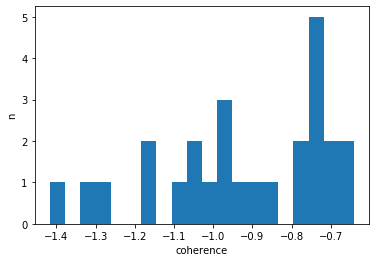

In [47]:
import matplotlib.pyplot as plt

plt.hist(coh, bins=20)
plt.xlabel('coherence')
plt.ylabel('n')
plt.show();

And print the best and worst topics according to this metric:

In [48]:
import numpy as np

top10_t_indices = np.argsort(coh)[::-1][:5]
bottom10_t_indices = np.argsort(coh)[:5]

topic_labels[top10_t_indices]

array(['9_county_committee', '15_board_member', '24_amount_account',
       '3_program_agency', '16_authorize_development'], dtype='<U24')

In [49]:
topic_labels[bottom10_t_indices]

array(['6_school_student', '18_work_exist', '7_maintain_know',
       '13_casino_license', '26_martin_llc'], dtype='<U24')

More coherence metrics can be used with the function [metric_coherence_gensim()](api.rst#tmtoolkit.topicmod.evaluate.metric_coherence_gensim). This requires that [gensim](https://radimrehurek.com/gensim/) is installed. Furthemore, most metrics require that a parameter `texts` is passed which is the tokenized text that was used to create the document-term matrix.

### Filtering topics

With the function [filter_topics()](api.rst#tmtoolkit.topicmod.model_stats.filter_topics), you can filter the topics according to their topic-word distribution and the following search criteria:

- `search_pattern`: one or more search patterns according to the [common parameters for pattern matching](preprocessing.ipynb#Common-parameters-for-pattern-matching-functions)
- `top_n`: pattern match(es) must occur in the first `top_n` most probable words in the topic
- `thresh`: matched words' probability must be above this threshold

You must specify at least one of `top_n` and `thresh`, but you can also specify both. The function returns an array of topic indices (which start with zero!).

Let's find all topics that have the word "police" in the top 5 most probable words:

In [ ]:
from tmtoolkit.topicmod.model_stats import filter_topics

found_topics = filter_topics('finance', vocab,
                             best_tm.topic_word_, top_n=5)
found_topics

We can use these indices with our `topic_labels`:

In [ ]:
topic_labels[found_topics]

Next, we want to select all topics where *any* of the words matched by the glob patterns (`match_type='glob'`) `"trump"` *or* `"russia*"` achieve at least a probability of 0.01 (`thresh=0.01`):

In [ ]:
found_topics = filter_topics(['finance', 'contract*'], vocab,
                             best_tm.topic_word_, thresh=0.01, match_type='glob')
topic_labels[found_topics]

When we specify `cond='all'`, *all* patterns must have at least one match (here in the top 50 list of words per topic):

In [ ]:
found_topics = filter_topics(['finance', 'contract*'], vocab,
                             best_tm.topic_word_, top_n=50, match_type='glob',
                             cond='all')
topic_labels[found_topics]

### Excluding topics

It is often the case that some topics of a topic model rank a lot of uninformative (e.g. very common) words the highest. This results in some uninformative topics, which you may want to exclude from further analysis. Note that if a large fraction of topics seems uninformative, it points to a problem with your topic model and/or your preprocessing steps. You should [evaluate](#Evaluation-of-topic-models) your candidate models carefully with the mentioned metrics and/or adjust your text preprocessing pipeline.

The function [exclude_topics()](api.rst#tmtoolkit.topicmod.model_stats.exclude_topics) allows to remove a specified set of topics from the document-topic and topic-word distributions. You need to pass the **zero-based** indices of the topics that you want to remove, and both distributions.

In this example, I identified the following topics as uninformative (by looking at the top ranked words either by topic-word distribution or topic-word relevance):

In [ ]:
topic_labels[bottom10_t_indices]

We can now pass these indices to [exclude_topics()](api.rst#tmtoolkit.topicmod.model_stats.exclude_topics) along with the topic model distributions. We'll get back new, filtered, distributions.

In [ ]:
from tmtoolkit.topicmod.model_stats import exclude_topics

new_doc_topic, new_topic_word, new_topic_mapping = \
    exclude_topics(uninform_topics, best_tm.doc_topic_,
                best_tm.topic_word_, return_new_topic_mapping=True)
new_doc_topic.shape, new_topic_word.shape

We can see in the new distributions' shapes that we now have 45 instead of 50 topics, because we removed five of them. We shouldn't forget to also update the topic labels and remove the unwanted topics:

In [ ]:
new_topic_labels = np.delete(topic_labels, uninform_topics)
new_topic_labels

## Displaying topic modeling results

The [topicmod.model_io](api.rst#module-tmtoolkit.topicmod.model_io) module provides several functions for displaying and exporting topic modeling results, i.e. results derived from the document-topic and topic-word distribution of a given topic model.

We already used [ldamodel_top_topic_words()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_topic_words) briefly, which generates a dataframe with the top words from a topic-word distribution. You can also use the topic-word relevance matrix instead. With `top_n` we can control the number of top words:

In [ ]:
# using relevance matrix here and showing only the first 3 topics
ldamodel_top_topic_words(topic_word_rel, vocab, top_n=5)[:3]

Note that the values in parantheses are the corresponding values from the matrix for that word in that topic. They're negative because of the log transformation that is applied in the topic-word relevance measure.

A similar function can be used for the document-topic distribution: [ldamodel_top_doc_topics()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_doc_topics). Here, `top_n` controls the number of top-ranked topics to export. This time, we use the filtered document-topic distribution `new_doc_topics`:

In [ ]:
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics

ldamodel_top_doc_topics(best_tm.doc_topic_, doc_labels, top_n=3,
                        topic_labels=topic_labels)[:5]

Let's have a look at one of these documents:

In [ ]:
print(corpus['10046'][:500], '...')

There are also two functions that generate datatables for the full topic-word and document-topic distributions: [ldamodel_full_topic_words()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_full_topic_words) and [ldamodel_full_doc_topics()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_full_doc_topics). The output of both functions is naturally quite big, as long as you're not working with a "toy dataset".

In [ ]:
from tmtoolkit.topicmod.model_io import ldamodel_full_topic_words

datatable_topic_word = ldamodel_full_topic_words(best_tm.topic_word_,
                                                 vocab,
                                                 row_labels=topic_labels)
# displaying only the first 5 topics with the first
# 10 words from the vocabulary (which are all numbers)
#datatable_topic_word[:5, :10]
datatable_topic_word[:5]

In [ ]:
from tmtoolkit.topicmod.model_io import ldamodel_full_doc_topics

datatable_doc_topic = ldamodel_full_doc_topics(best_tm.doc_topic_,
                                               doc_labels,
                                               topic_labels=topic_labels)
# displaying only the first 3 documents with the first
# 5 topics
#datatable_doc_topic[:3, :5]
datatable_doc_topic[:3]

For quick inspection of topics there's also a pair of print functions. We already used [print_ldamodel_topic_words()](api.rst#tmtoolkit.topicmod.model_io.print_ldamodel_topic_words), but we haven't tried [print_ldamodel_doc_topics()](api.rst#tmtoolkit.topicmod.model_io.print_ldamodel_doc_topics) yet. This prints the `top_n` most probable topics for each document:

In [ ]:
from tmtoolkit.topicmod.model_io import print_ldamodel_doc_topics

# subsetting new_doc_topic and doc_labels to get only the first
# five documents
print_ldamodel_doc_topics(best_tm.doc_topic_[:5, :], doc_labels[:5],
                          val_labels=topic_labels)

## Visualizing topic models

The [topicmod.visualize](api.rst#visualize-topic-models-and-topic-model-evaluation-results) module contains several functions to visualize topic models and evaluation results. We've already used [plot_eval_results()](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results) during [topic model evaluation](#Evaluation-of-topic-models) so we'll now focus on visualizing topic models.

### Heatmaps

Let's start with heatmap visualizations of document-topic or topic-word distributions from our topic model. This can be done with [plot_doc_topic_heatmap()](api.rst#tmtoolkit.topicmod.visualize.plot_doc_topic_heatmap) and [plot_topic_word_heatmap()](api.rst#tmtoolkit.topicmod.visualize.plot_topic_word_heatmap) respectively. Both functions draw on a [matplotlib](https://matplotlib.org/) figure and *Axes* object, which you must create before using these functions.

Heatmap visualizations essentially shade cells in a 2D matrix (like the document-topic or topic-word distributions) according to their value, i.e. the respective probability for a topic in a given document or a word in a given topic. Since these matrices are usually quite large, i.e. with hundreds of rows and/or columns, it doesn't make sense to plot a heatmap of the whole matrix, but rather a certain subset of interest. When we want to visualize a document-topic distribution, we can optionally select a subset of the documents with the `which_documents` parameter and a subset of the topics with the `which_topics` parameter. Let's draw a heatmap of a subset of documents across all topics at first:

In [ ]:
import matplotlib.pyplot as plt
from tmtoolkit.topicmod.visualize import plot_doc_topic_heatmap

# create a figure of certain size and
# Axes object to draw on
fig, ax = plt.subplots(figsize=(32, 8))

which_docs = list(corpus.keys())[:10]

plot_doc_topic_heatmap(fig, ax, best_tm.doc_topic_, doc_labels,
                       topic_labels=topic_labels,
                       which_documents=which_docs);

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))

which_topics = [
    '10_employee_retirement',
    '13_appointing_settlement',
    '15_december_red',
    '18_station_asap',
    '19_delivery_strategic'
]

plot_doc_topic_heatmap(fig, ax, best_tm.doc_topic_, doc_labels,
                       topic_labels=topic_labels,
                       which_documents=which_docs,
                       which_topics=which_topics);

Similarily, we can work with [plot_topic_word_heatmap()](api.rst#tmtoolkit.topicmod.visualize.plot_topic_word_heatmap) to visualize a topic-word distribution. We can also select a subset of topics and words from the vocabulary:

In [ ]:
from tmtoolkit.topicmod.visualize import plot_topic_word_heatmap

fig, ax = plt.subplots(figsize=(12, 8))

which_words = ['finance', 'budget', 'project', 'contract']

plot_topic_word_heatmap(fig, ax, best_tm.topic_word_, vocab,
                        topic_labels=topic_labels,
                        which_topics=which_topics,
                        which_words=which_words);

Note that there's also a generic heatmap plotting function [plot_heatmap()](api.rst#plot-heatmaps-for-topic-models) for any kind of 2D matrices. 

### Word clouds

Thanks to the [wordlcloud package](https://pypi.org/project/wordcloud/), topic-word and document-topic distributions can also be visualized as "word clouds" with tmtoolkit. The function [generate_wordclouds_for_topic_words()](api.rst#tmtoolkit.topicmod.visualize.generate_wordclouds_for_topic_words) generates a word cloud for each topic by scaling a topic's word by its probability (weight). You can choose to display only the top `top_n` words per topic. The result of this function will be a dictionary mapping topic labels to the respective word cloud image.

In [ ]:
from tmtoolkit.topicmod.visualize import generate_wordclouds_for_topic_words

# some options for wordcloud output
img_w = 400   # image width
img_h = 300   # image height

topic_clouds = generate_wordclouds_for_topic_words(
    new_topic_word, vocab_bg,
    top_n=20, topic_labels=new_topic_labels,
    width=img_w, height=img_h
)

# show all generated word clouds
topic_clouds.keys()

Let's select specific topics and display their word cloud:

In [ ]:
topic_clouds['13_appointing_settlement']

In [ ]:
topic_clouds['10_employee_retirement']

The same can be done for the document-topic distribution using [generate_wordclouds_for_document_topics()](api.rst#tmtoolkit.topicmod.visualize.generate_wordclouds_for_document_topics). Here, a word cloud for each document will be generated that contains the `top_n` most probable topics for this document:

In [ ]:
from tmtoolkit.topicmod.visualize import generate_wordclouds_for_document_topics

doc_clouds = generate_wordclouds_for_document_topics(
    new_doc_topic, doc_labels, topic_labels=new_topic_labels,
    top_n=5, width=img_w, height=img_h)

# show only the first 5 documents for
# which word clouds were generated
list(doc_clouds.keys())[:5]

To display a specific document's topic word cloud:

In [ ]:
doc_clouds['1']